## *DISCLAIMER*
<p style="font-size:16px; color:#117d30;">
 By accessing this code, you acknowledge the code is made available for presentation and demonstration purposes only and that the code: (1) is not subject to SOC 1 and SOC 2 compliance audits; (2) is not designed or intended to be a substitute for the professional advice, diagnosis, treatment, or judgment of a certified financial services professional; (3) is not designed, intended or made available as a medical device; and (4) is not designed or intended to be a substitute for professional medical advice, diagnosis, treatment or judgement. Do not use this code to replace, substitute, or provide professional financial advice or judgment, or to replace, substitute or provide medical advice, diagnosis, treatment or judgement. You are solely responsible for ensuring the regulatory, legal, and/or contractual compliance of any use of the code, including obtaining any authorizations or consents, and any solution you choose to build that incorporates this code in whole or in part.
</p>

<p style="font-size:25px; color:black;"><u><i><b>Predicting the number of customers likely to visit different departments in a store</b></i></u></p>
<p style="font-size:16px; color:#117d30;">
    Time series forecasting is the use of a model to predict future values based on previously observed values.
The AutoML feature of AzureSynapse, in this case uses more than 25 time series forecasting machine learning algorithms to predicts how many customers are likely to visit different departments in a store.
</p>
Note:
</p>
<p style="font-size:15px; color:#117d30;">
 This notebook is written in Scala, and there is interoperability between Scala and Python code.
</p>

<p style="font-size:15px; color:#117d30;">
    <u> Abstract: </u>
</p>
<p style="font-size:16px; color:#117d30;">
1) Ingest  data from Azure Synapse Data Storage account using PySpark.
</p>
<p style="font-size:16px; color:#117d30;">
2) Exploratory Data Analysis 
</p>
<p style="font-size:15px; color:#117d30;">
3) Training more than 25 time series forecasting machine learning algorithms.
</p>
<p style="font-size:15px; color:#117d30;">
4) Predict the number of customers likely to visit different departments in a store by choosing the best performing Machine Learning Algorithm..
</p>


## Introduction
<p style="font-size:16px; color:#117d30;">


### In this notebook we showcased how to:
<p style="font-size:16px; color:#117d30;">
1. Create an experiment using an existing workspace

<p style="font-size:16px; color:#117d30;">
2. Configure AutoML using 'AutoMLConfig'

<p style="font-size:16px; color:#117d30;">
3. Train the model 

<p style="font-size:16px; color:#117d30;">
4. Explore the engineered features and results

<p style="font-size:16px; color:#117d30;">
5. Configuration and remote run of AutoML for a time-series model with lag and rolling window features

<p style="font-size:16px; color:#117d30;">
6. Run and explore the forecast

<p style="font-size:16px; color:#117d30;">
7. Register the model





### Importing required libraries such as azureml, pandas, pandasql, pyspark, and other supporting libraries.



## Cell title


In [3]:
# ∗∗∗∗∗∗∗∗∗∗ Important – Do not use in production, for demonstration purposes only – please review the legal notices before continuing ∗∗∗∗∗

%%pyspark
from azureml.train.automl import AutoMLConfig
# from azureml.widgets import RunDetails
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl.run import AutoMLRun
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
from pyspark.sql.window import Window
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.model import Model
from azureml.core.webservice import Webservice
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.environment import Environment

import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns 
import azureml.train.automl.runtime
import logging
import os, tempfile
import pandas as pd 
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark import SparkContext

os.environ['AZURE_SERVICE']="Microsoft.ProjectArcadia"

## *Connecting to Azure Synapse Data Warehouse*
<p style="font-size:16px; color:#117d30;">
    Connection to Azure Synapse Data Warehouse is initiated and the required data is ingested for processing.
    The warehouse is connected with a single line of code. Just point to actions in a table, click on a new notebook, and then click on "Load to DataFrame".  </p>
   <p style="font-size:16px; color:#117d30;"> After providing the necessary details,  the required data is loaded in the form of a Spark dataframe.
One magical line of code converts a dataframe from Scala to Python!
</p>


In [4]:
%%pyspark
department_visits = spark.read.load('abfss://customer-churn-data@#STORAGE_ACCOUNT_NAME#.dfs.core.windows.net/department_visit_customers_latest.csv'
    ,format='csv'
    ,header=True)
department_visits.show(10)

+----------+-----------------+-------------------+------+----+----+-------------+------+
|      Date|Accessories_count|Entertainment_count|Gaming|Kids|Mens|Phone_and_GPS|Womens|
+----------+-----------------+-------------------+------+----+----+-------------+------+
|2015-06-08|              309|                 37|    67|  74|  46|           12|    73|
|2020-01-26|              367|                 20|    32|  73|  56|           88|    98|
|2019-10-21|              419|                 64|    68|  41|  97|           88|    61|
|2019-02-04|              481|                 46|    91|  96|  75|           92|    81|
|2017-04-16|              162|                 25|    20|  30|  29|           32|    26|
|2015-11-30|              283|                 53|    81|  14|  47|           87|     1|
|2016-12-02|              280|                 51|    54|  46|  42|           73|    14|
|2018-09-29|              295|                 67|    52|  66|   8|           82|    20|
|2020-12-15|         

# Exploratory Data Analysis

<p style="font-size:16px; color:#117d30;">
The goal of performing exploratory data analysis is to understand the underlying patterns and correlations among features in the data. 


In [5]:
%%pyspark

department_visit_data = department_visits.select("*").toPandas()
department_visit_data['Date'] = pd.to_datetime(department_visit_data['Date']).dt.strftime('%m/%d/%y')
department_visit_data['Month'] = pd.to_datetime(department_visit_data['Date']).dt.strftime('%m')
department_visit_data['DayOfMonth'] = pd.to_datetime(department_visit_data['Date']).dt.strftime('%d')
department_visit_data['Year'] = pd.to_datetime(department_visit_data['Date']).dt.strftime('%y')
department_visit_data['DayOfWeek'] = pd.to_datetime(department_visit_data['Date']).dt.strftime('%a')
department_visit_data[['Accessories_count','Entertainment_count','Gaming','Kids','Mens','Phone_and_GPS','Womens']] = \
    department_visit_data[['Accessories_count','Entertainment_count','Gaming','Kids','Mens','Phone_and_GPS','Womens']].apply(pd.to_numeric)

#display(department_visit_data)

/home/trusted-service-user/cluster-env/env/lib/python3.6/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)

##  Deriving insights from customer visits data  

<p style="font-size:16px; color:#117d30;">
1. Heat Map: Thickness of the color indicates the no of customers visiting the section on that particular day. It provides a quick representation of distribution of traffic across days and in various departments. From the graph, we can infer that more number of customers visit the Entertainment department on Wednesdays, Thursdays and Fridays and there is less foot traffic on Mondays and Fridays in the Phone_and_gps department.


In [6]:
df_dow = department_visit_data.groupby('DayOfWeek').sum().sort_values(by = 'DayOfWeek', 
                                                                 ascending=True)
df_dow.head(100)

Accessories_count  Entertainment_count   ...    Phone_and_GPS  Womens
DayOfWeek                                           ...                         
Fri                  1712790               293214   ...           290116  280354
Mon                  1666042               281208   ...           278190  274172
Sat                  1692044               285128   ...           286570  280190
Sun                  1620544               264874   ...           271028  270102
Thu                  1693190               282844   ...           278942  283104
Tue                  1709668               283106   ...           280766  288812
Wed                  1777856               292008   ...           294800  296440

[7 rows x 7 columns]

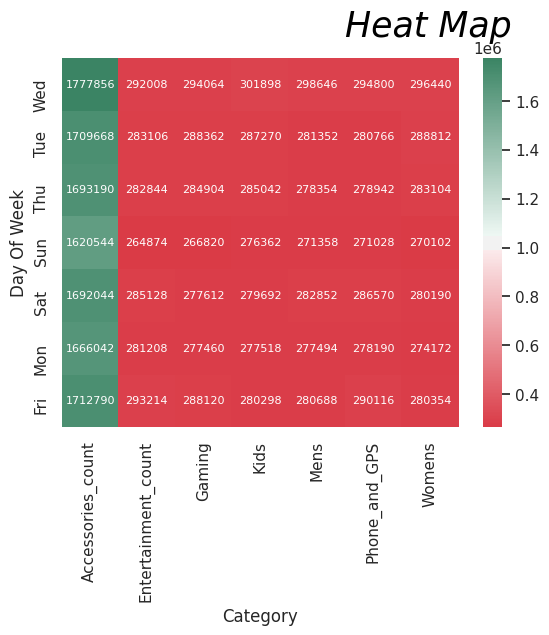

In [7]:
sns.set()
plt.rcParams['font.size'] = 12
bg_color = (0.88,0.85,0.95)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color
fig, ax = plt.subplots(1)
cmap = sns.diverging_palette(10, 150, n=2, as_cmap=True)
#cmap = sns.color_palette("hls", 150)

p = sns.heatmap(df_dow,
                cmap=cmap,
                annot=True,
                fmt="d",
                annot_kws={'size':8},
                ax=ax)
plt.xlabel('Category')
plt.ylabel('Day Of Week')
ax.set_ylim((0,7))
plt.text(5,7.4, "Heat Map", fontsize = 25, color='Black', fontstyle='italic')
 
plt.show()

# Data Manipulation  
<p style="font-size:16px; color:#117d30;">
1. Converting date to a specific format and making date fields relevant for prediction.

<p style="font-size:16px; color:#117d30;">
2. Converting the data type of the columns to numeric before being passed as input to the model.


In [10]:
%%pyspark
department_visit_data = department_visits.select("*").toPandas()
department_visit_data['Date'] = pd.to_datetime(department_visit_data['Date']).dt.strftime('%Y-%m-%d')

department_visit_data[['Accessories_count','Entertainment_count','Gaming','Kids','Mens','Phone_and_GPS','Womens']] = \
    department_visit_data[['Accessories_count','Entertainment_count','Gaming','Kids','Mens','Phone_and_GPS','Womens']].apply(pd.to_numeric)

grouped_data = department_visit_data.groupby('Date', as_index=False).sum()


total_rows = grouped_data.count
print(total_rows)

<bound method DataFrame.count of             Date  Accessories_count   ...    Phone_and_GPS  Womens
0     2014-12-31                812   ...              176     152
1     2015-01-01               3498   ...              492     384
2     2015-01-02               6742   ...             1772     952
3     2015-01-03               6508   ...              908    1424
4     2015-01-04               7248   ...             1582    1260
5     2015-01-05               2330   ...              404     374
6     2015-01-06               4774   ...              624     676
7     2015-01-07               4960   ...              628     834
8     2015-01-08               5054   ...             1040     860
9     2015-01-09               7292   ...             1312    1154
10    2015-01-10               4090   ...              812     356
11    2015-01-11               7388   ...              838    1160
12    2015-01-12               7078   ...             1208    1006
13    2015-01-13             

In [11]:
%%pyspark
accessories_data = grouped_data[['Date','Accessories_count']]
entertainment_data = grouped_data[['Date','Entertainment_count']]
gaming_data = grouped_data[['Date','Gaming']]
kids_data = grouped_data[['Date','Kids']]
mens_data = grouped_data[['Date','Mens']]
phone_and_GPS_data = grouped_data[['Date','Phone_and_GPS']]
womens_data = grouped_data[['Date','Womens']]

accessories_data['Department']='Accessories'
entertainment_data['Department']='Entertainment'
gaming_data['Department']='Gaming'
kids_data['Department']='Kids'
mens_data['Department']='Mens'
phone_and_GPS_data['Department']='Phone_and_GPS'
womens_data['Department']='Womens'

accessories_data= accessories_data.rename(columns={'Accessories_count': 'Visits'})
entertainment_data= entertainment_data.rename(columns={ 'Entertainment_count':'Visits'})
gaming_data = gaming_data.rename(columns={'Gaming': 'Visits'})
kids_data = kids_data.rename(columns={'Kids': 'Visits'})
mens_data = mens_data.rename(columns={'Mens': 'Visits'})
phone_and_GPS_data = phone_and_GPS_data.rename(columns={'Phone_and_GPS': 'Visits'})
womens_data = womens_data.rename(columns={'Womens': 'Visits'})
df_customervisits = accessories_data.append( entertainment_data).append(gaming_data).append(kids_data).append(mens_data).append(phone_and_GPS_data).append(womens_data)

df_customervisits

Date  Visits   Department
0     2014-12-31     812  Accessories
1     2015-01-01    3498  Accessories
2     2015-01-02    6742  Accessories
3     2015-01-03    6508  Accessories
4     2015-01-04    7248  Accessories
5     2015-01-05    2330  Accessories
6     2015-01-06    4774  Accessories
7     2015-01-07    4960  Accessories
8     2015-01-08    5054  Accessories
9     2015-01-09    7292  Accessories
10    2015-01-10    4090  Accessories
11    2015-01-11    7388  Accessories
12    2015-01-12    7078  Accessories
13    2015-01-13    6344  Accessories
14    2015-01-14    8678  Accessories
15    2015-01-15    4856  Accessories
16    2015-01-16    7476  Accessories
17    2015-01-17    8282  Accessories
18    2015-01-18    8458  Accessories
19    2015-01-19     614  Accessories
20    2015-01-20    7244  Accessories
21    2015-01-21    8660  Accessories
22    2015-01-22    4564  Accessories
23    2015-01-23    9626  Accessories
24    2015-01-24    4440  Accessories
25    2015-01-25    4000

In [12]:
%%pyspark
total_rows = df_customervisits.count
print(total_rows)

<bound method DataFrame.count of             Date  Visits   Department
0     2014-12-31     812  Accessories
1     2015-01-01    3498  Accessories
2     2015-01-02    6742  Accessories
3     2015-01-03    6508  Accessories
4     2015-01-04    7248  Accessories
5     2015-01-05    2330  Accessories
6     2015-01-06    4774  Accessories
7     2015-01-07    4960  Accessories
8     2015-01-08    5054  Accessories
9     2015-01-09    7292  Accessories
10    2015-01-10    4090  Accessories
11    2015-01-11    7388  Accessories
12    2015-01-12    7078  Accessories
13    2015-01-13    6344  Accessories
14    2015-01-14    8678  Accessories
15    2015-01-15    4856  Accessories
16    2015-01-16    7476  Accessories
17    2015-01-17    8282  Accessories
18    2015-01-18    8458  Accessories
19    2015-01-19     614  Accessories
20    2015-01-20    7244  Accessories
21    2015-01-21    8660  Accessories
22    2015-01-22    4564  Accessories
23    2015-01-23    9626  Accessories
24    2015-01-24 

## Train

<p style="font-size:16px; color:#117d30;">
1. Instantiate an AutoMLConfig object. 
<p style="font-size:16px; color:#117d30;">
2. The configuration below defines the settings and data used to run the experiment. 


## Set AutoML Configuration Parameters

<p style="font-size:16px; color:#117d30;">
    The forecast horizon is the number of periods into the future that the model should predict. 

<p style="font-size:16px; color:#117d30;">
    It is generally recommended that users set forecast horizons to less than 100 time periods

<p style="font-size:16px; color:#117d30;">
    Furthermore, AutoML's memory use and computation time increases in proportion to the length of the horizon, so consider carefully how this value is set. 

<p style="font-size:16px; color:#117d30;">
    If a long horizon forecast really is necessary, consider aggregating the series to a coarser time scale.


In [13]:
%%pyspark
automl_settings = {
   'time_column_name':'Date',
   'grain_column_names': ['Department'],
   'max_horizon': 25
}

In [17]:
%%pyspark
automl_config = AutoMLConfig( 
                            #forecasting for time-series tasks
                            task='forecasting',
                            #measuere for evaluating the performance of the models
                            primary_metric='normalized_root_mean_squared_error',
                            #Maximum amount of time in minutes that the experiment take before it terminates.
                            experiment_timeout_minutes=15,
                            enable_early_stopping=True,
                            training_data=df_customervisits,#train_data,
                            label_column_name='Visits',
                            #Rolling Origin Validation is used to split time-series in a temporally consistent way.
                            n_cross_validations=4,
                            # Flag to enble early termination if the score is not improving in the short term.
                            enable_ensembling=False,
                            verbosity=logging.INFO,
                            **automl_settings)

In [18]:
%%pyspark
subscription_id='#SUBSCRIPTION_ID#'
resource_group='#RESOURCE_GROUP_NAME#'
workspace_name='#AML_WORKSPACE_NAME#'
ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
ws.write_config()
ws = Workspace.from_config()
experiment = Experiment(ws, "Department_Visit_Count_V3")

## Run The Experiment
<p style="font-size:16px; color:#117d30;">
Automated ML runs more than 25 Machine Learning Algorithms and grades them according to performance.


In [48]:
%%pyspark
model_name = "Department-Visits-Forecast-Model"
description = "Forecasting Machine Learning model to predict department visits"
tags = {'WWI': 'DepartmentVisitsPredictions'}


matching_models = Model.list(ws, model_name, latest=True)
if len(matching_models) > 0:
    run = AutoMLRun(experiment, matching_models[0].run_id)
    automl_run = AutoMLRun(experiment, run.parent.id)
    best_run, fitted_model = automl_run.get_output()
else:
    local_run = experiment.submit(automl_config, show_output=True)
    best_run, fitted_model = local_run.get_output()
    model = local_run.register_model(model_name=model_name, description = description, tags = tags)

fitted_model

ForecastingPipelineWrapper(pipeline=Pipeline(memory=None,
     steps=[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None, logger=None,
           pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('MaxAbsScaler', MaxAbsScaler(copy=True)), ('DecisionTreeRegressor', DecisionTreeRegressor(criterion='friedman_mse', max_depth=None,
           ...       min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'))]),
              stddev=None)

In [49]:
%%pyspark
#future_date =  pd.date_range(start='2015-12-1', end='2015-12-5')
#future_data = pd.DataFrame({'Date':future_date, 'Department':'Accessories', 'Visits':0})

future_date =  pd.date_range(start='2021-01-01', end='2021-01-20').values
future_data = pd.DataFrame({'Date':future_date, 'Department':'Womens'})
future_data = future_data.append(pd.DataFrame({'Date':future_date, 'Department':'Mens'}), ignore_index=True)
future_data = future_data.append(pd.DataFrame({'Date':future_date, 'Department':'Entertainment'}), ignore_index=True)
future_data = future_data.append(pd.DataFrame({'Date':future_date, 'Department':'Gaming'}), ignore_index=True)
future_data = future_data.append(pd.DataFrame({'Date':future_date, 'Department':'Kids'}), ignore_index=True)
future_data = future_data.append(pd.DataFrame({'Date':future_date, 'Department':'Accessories'}), ignore_index=True)
future_data = future_data.append(pd.DataFrame({'Date':future_date, 'Department':'Phone_and_GPS'}), ignore_index=True)

future_data

Date     Department
0   2021-01-01         Womens
1   2021-01-02         Womens
2   2021-01-03         Womens
3   2021-01-04         Womens
4   2021-01-05         Womens
5   2021-01-06         Womens
6   2021-01-07         Womens
7   2021-01-08         Womens
8   2021-01-09         Womens
9   2021-01-10         Womens
10  2021-01-11         Womens
11  2021-01-12         Womens
12  2021-01-13         Womens
13  2021-01-14         Womens
14  2021-01-15         Womens
15  2021-01-16         Womens
16  2021-01-17         Womens
17  2021-01-18         Womens
18  2021-01-19         Womens
19  2021-01-20         Womens
20  2021-01-01           Mens
21  2021-01-02           Mens
22  2021-01-03           Mens
23  2021-01-04           Mens
24  2021-01-05           Mens
25  2021-01-06           Mens
26  2021-01-07           Mens
27  2021-01-08           Mens
28  2021-01-09           Mens
29  2021-01-10           Mens
..         ...            ...
110 2021-01-11    Accessories
111 2021-01-12    Ac

## Making future prediction using model that performs best


In [50]:
y_predictions, X_trans = fitted_model.forecast(future_data)
X_trans.reset_index(inplace=True)
X_trans

Date     Department         ...          week  _automl_target_col
0   2021-01-01         Womens         ...            53              998.56
1   2021-01-02         Womens         ...            53              998.56
2   2021-01-03         Womens         ...            53              874.25
3   2021-01-04         Womens         ...             1              879.06
4   2021-01-05         Womens         ...             1              879.06
5   2021-01-06         Womens         ...             1              879.06
6   2021-01-07         Womens         ...             1              755.59
7   2021-01-08         Womens         ...             1              755.59
8   2021-01-09         Womens         ...             1              755.59
9   2021-01-10         Womens         ...             1              897.12
10  2021-01-11         Womens         ...             2              879.06
11  2021-01-12         Womens         ...             2              879.06
12  2021-01-13        

In [58]:
%%pyspark
table = pd.pivot_table(X_trans, values=['_automl_target_col'], index=['Date'], columns=['Department'])
#table['Date'] = table.index
table.columns = table.columns.droplevel()
table.reset_index(inplace=True)

table = table.astype({'Accessories': 'int32','Entertainment': 'int32','Gaming': 'int32','Kids': 'int32','Mens': 'int32','Phone_and_GPS': 'int32','Womens': 'int32'}, copy=False)

table.head(100)

Department       Date  Accessories   ...    Phone_and_GPS  Womens
0          2021-01-01         5378   ...              998     998
1          2021-01-02         5378   ...              998     998
2          2021-01-03         5177   ...              874     874
3          2021-01-04         5179   ...              879     879
4          2021-01-05         5179   ...              879     879
5          2021-01-06         5179   ...              879     879
6          2021-01-07         5179   ...              755     755
7          2021-01-08         5179   ...              755     755
8          2021-01-09         5179   ...              755     755
9          2021-01-10         5177   ...              897     897
10         2021-01-11         5179   ...              879     879
11         2021-01-12         5179   ...              879     879
12         2021-01-13         5179   ...              879     879
13         2021-01-14         5179   ...              755     755
14        

In [59]:
%%pyspark
predict_df = spark.createDataFrame(table, ['Date', 'Accessories', 'Entertainment', 'Gaming', 'Kids', 'Mens', 'Phone_and_GPS', 'Womens'])

In [61]:
%%pyspark
predict_df \
    .repartition(1) \
    .write.format('csv') \
    .option("header", "true") \
    .mode("overwrite") \
    .save('abfss://machine-learning@#DATA_LAKE_NAME#.dfs.core.windows.net/department-visit-predictions.csv')